In [1]:
#necessary if running in Google Colab
%pip install qiskit
%pip install pylatexenc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 15.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=2e47029acf30397ab0fcb4df39d98c7c3a9f5a9bfe5f71ff791704e777bb49da
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc


In [2]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Qubit
from qiskit.quantum_info import Statevector, Operator, random_unitary

from qiskit.circuit.library.standard_gates import HGate, XGate
from qiskit.circuit.library import RYGate, RZGate

import matplotlib.pyplot as plt

import numpy as np

#Z-Y Decomposition

Recall the following single qubit gates:

$R_y(\theta) =
\begin{bmatrix}
  \cos(\frac\theta2) & -\sin(\frac\theta2) \\
  \sin(\frac\theta2) & \cos(\frac\theta2)
\end{bmatrix}$

$R_z(\theta) =
\begin{bmatrix}
  e^{-i\theta/2} & 0 \\
  0 & e^{i\theta/2}
\end{bmatrix}
$

The implementation of multi-controlled gates depends on the fact for any unitary $U$, there exist real numbers $\alpha, \beta, \gamma, \delta$ such that
$U = e^{i\alpha}R_z(\beta)R_y(\gamma)R_z(\delta)$.

In [3]:
def ZYDecomposition(U):
  w,x,y,z = U[0][0], U[0][1], U[1][0], U[1][1]

  gamma = 2*np.arccos(np.absolute(w))
  a = np.angle(w)
  b = np.angle(y/np.sin(gamma/2))
  c = np.angle(z)
  alpha = (a + c)/2
  beta = b-a
  delta = c-b

  return alpha, beta, gamma, delta

U = random_unitary(2).to_matrix()
alpha, beta, gamma, delta = ZYDecomposition(U)
U2 = np.exp(1j*alpha)*RZGate(beta).to_matrix() @ RYGate(gamma).to_matrix() @ RZGate(delta).to_matrix()

In [8]:
#lets decompose a random unitary matrix
U = random_unitary(2).to_matrix()
U

array([[-0.04697865-0.21863566j, -0.76455572+0.60452131j],
       [-0.55416045+0.80180898j, -0.22120186-0.03283725j]])

In [9]:
alpha, beta, gamma, delta = ZYDecomposition(U)
Z1 = RZGate(beta).to_matrix()
Y = RYGate(gamma).to_matrix()
Z2 = RZGate(delta).to_matrix()
U2 = np.exp(1j*alpha)*Z1 @ Y @ Z2
U2

array([[-0.04697865-0.21863566j, -0.76455572+0.60452131j],
       [-0.55416045+0.80180898j, -0.22120186-0.03283725j]])

#Singly-Controlled Gate

Given a single qubit gate $U$, we can implement the controlled version $CU$ by first obtaining $\alpha, \beta, \gamma, \delta$ as above and then noticing that for

$A := R_z(\beta)R_y(\frac\gamma 2)$

$B := R_y(\frac{-\gamma} 2)R_z(\frac{-\delta - \beta} 2)$

$C := R_z(\frac{\delta - \beta}2)$

we have $ABC = I$ and $e^{i\alpha}AXBXC = U$.

In [19]:
def SingleControlledGate(U):
  alpha, beta, gamma, delta = ZYDecomposition(U)
  A = RZGate(beta).to_matrix() @ RYGate(gamma/2).to_matrix()
  B = RYGate(-gamma/2).to_matrix() @ RZGate(-(delta + beta)/2).to_matrix()
  C = RZGate((delta-beta)/2).to_matrix()

  register = QuantumRegister(2,name="x")
  CU = QuantumCircuit(register)
  #apply C
  CU.rz((delta-beta)/2, register[1])
  #apply controlled X
  CU.cx(register[0], register[1])
  #apply B
  CU.rz((-delta-beta)/2, register[1])
  CU.ry(-gamma/2, register[1])
  #apply controlled X
  CU.cx(register[0], register[1])
  #apply A
  CU.ry(gamma/2, register[1])
  CU.rz(beta, register[1])
  CU.p(alpha, register[0])

  return CU

In [27]:
#let's confirm this implementation works
U = random_unitary(2).to_matrix()
U

array([[ 0.73047212-0.64200732j,  0.19755796-0.12332044j],
       [-0.10957874-0.20549837j,  0.31227036+0.92100496j]])

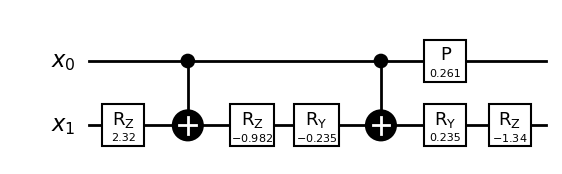

In [28]:
CU = SingleControlledGate(U)
CU.draw(output="mpl", style="bw")

In [33]:
np.round(Operator(CU).data, 3)

array([[ 1.   -0.j   ,  0.   +0.j   , -0.   -0.j   ,  0.   +0.j   ],
       [ 0.   +0.j   ,  0.73 -0.642j,  0.   +0.j   ,  0.198-0.123j],
       [ 0.   -0.j   ,  0.   +0.j   ,  1.   +0.j   ,  0.   +0.j   ],
       [ 0.   +0.j   , -0.11 -0.205j,  0.   +0.j   ,  0.312+0.921j]])

#Multi-Controlled Gate

Given an array of qubits (controls) and a quantum gate (U) returns the controlled version of U.

In [ ]:
#given a 2x2 unitary matrix U,
#returns a list [alpha, A, B, C]
#where U = exp(i*alpha)AXBXC and
#ABC = I
def ABCDecomposition(U):
  w,x,y,z = U[0][0], U[0][1], U[1][0], U[1][1]
  gamma = 2*np.arccos(np.absolute(w))
  alpha = (np.angle(x) + np.angle(w))/2
  beta = (np.angle(z) - np.angle(x))
  delta = 2*(np.angle(w) - alpha - beta/2)

  A = RZGate(beta).to_matrix() @ RYGate(gamma/2).to_matrix()
  B = RYGate(-gamma/2).to_matrix() @ RZGate(-(delta + beta)/2).to_matrix()
  C = RZGate((delta-beta)/2).to_matrix()

  print(alpha, beta, gamma, delta)

  return [alpha, A, B, C]


In [ ]:
M = np.array([[1,1],[1,-1]])/np.sqrt(2)

M[1][0]

np.angle(10)

np.float64(0.0)

In [ ]:
alpha, A,B,C = ABCDecomposition(M)

X = np.array([[0,1],[1,0]])
print("alpha = ", alpha)
print("A = ", np.round(A,3))
print("B = ", np.round(B,3))
print("C = ", np.round(C,3))
print(np.round(A @ B @ C))
print(np.round(A @ X @ B @ X @ C))

0.0 3.141592653589793 1.5707963267948968 -3.141592653589793
alpha =  0.0
A =  [[ 0.-0.924j -0.+0.383j]
 [ 0.+0.383j  0.+0.924j]]
B =  [[ 0.924+0.j  0.383+0.j]
 [-0.383+0.j  0.924+0.j]]
C =  [[0.+1.j 0.+0.j]
 [0.+0.j 0.-1.j]]
[[ 1.+0.j -0.+0.j]
 [-0.+0.j  1.+0.j]]
[[ 1.+0.j  1.+0.j]
 [-1.+0.j  1.+0.j]]


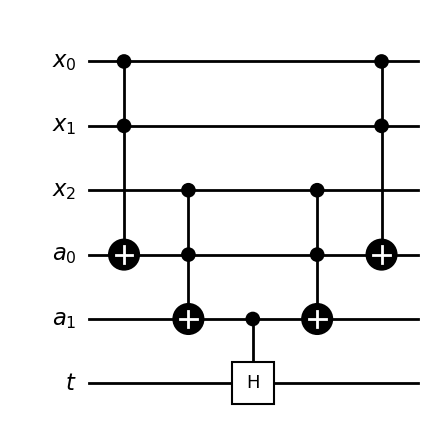

In [ ]:
def MultiControlledGate(n ,U):
  control_register = QuantumRegister(size=n, name="x")
  ancilla_register = AncillaRegister(size=n-1, name="a")
  target_register = QuantumRegister(size=1, name="t")

  #prepares a subroutine which stores the conjunction of all the x[i]s in a[n-2]
  setup = QuantumCircuit(control_register, ancilla_register, name="setup")
  setup.ccx(control_register[0], control_register[1], ancilla_register[0])
  for i in range(2, n):
    setup.ccx(control_register[i], ancilla_register[i-2], ancilla_register[i-1])

  final = QuantumCircuit(control_register, ancilla_register, target_register, name="multicontrolledU")
  final.compose(setup, inplace=True)
  final.append(U.control(1), [ancilla_register[n-2], target_register[0]])
  final.compose(setup.inverse(), inplace=True)

  return final

MultiControlledGate(3,HGate()).draw(output="mpl", style="bw")

This method is useful because the number of gates used is linear in the number of control qubits. The downside is that the number of ancilla qubits used is also linear in the number of control qubits.

Below we give another implementation, in which the number of gates is still linear in the number of control qubits, but now now only two ancilla qubits are used.

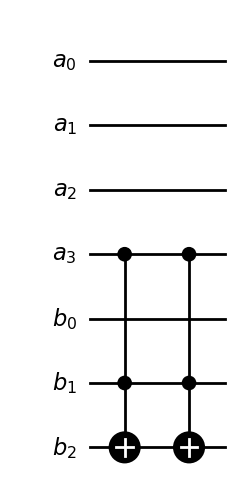

In [ ]:
def Flip_Base():
  a_register = QuantumRegister(size=2, name = "a")
  b_register = QuantumRegister(size=1, name = "b")
  F = QuantumCircuit(a_register, b_register)
  F.ccx(a_register[0], a_register[1], b_register[0])
  return F

def Flip(n):
  if n == 2:
    return Flip_Base()
  a_register = QuantumRegister(size=n, name = "a")
  b_register = QuantumRegister(size=n-1, name = "b")
  F = QuantumCircuit(a_register, b_register)
  F.ccx(a_register[n-1], b_register[n-3], b_register[n-2])
  F.compose(Flip(n-1))
  F.ccx(a_register[n-1], b_register[n-3], b_register[n-2])
  return F

Flip(4).draw(output="mpl", style="bw")